# Generative Adversarial Networks

In this jupyter notebook we implement generative adversarial networks which allows to generate data from the training data distribution.
[Generative adversarial networks](https://en.wikipedia.org/wiki/Generative_adversarial_network) implement a form of unsupervised learning.
The main idea is that there is a generator network $G$, generating data $\hat{x}$ out of some random input $z$ from the latent space. Additionally,  there is a discriminator network $D$ which outputs the probability whether $\hat{x}$ is generated or actually is a true training example $x \sim p(X)$.
Both, the generator $G$ and the discriminator $D$ play a zero-sum game (ideally) resulting in a Nash equilibrium where neither the discriminator can predict with more than 50\% accuracy whether $\hat{x}$ is fake or real and also the generator cannot trick the discriminator into classifying more than 50% of the generated data as real.

In [1]:
import numpy as np
import torch
from torch import autograd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from einops.layers.torch import Rearrange
import matplotlib
import matplotlib.pyplot as plt

## Loading the Training Data

Here we will use the (balanced) MNIST dataset containing the numbers 0 to 9. Below you see a random choice of training examples.

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                # transform from[0,1] to [-1,1]
                                transforms.Normalize((0.5,), (0.5,)),
                                ])
mb_size = 100
training_data = torchvision.datasets.MNIST(
    "../variational-autoencoder/data/MNIST", "balanced", download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(training_data,
                                          batch_size=mb_size,
                                          shuffle=True,
                                          num_workers=2)

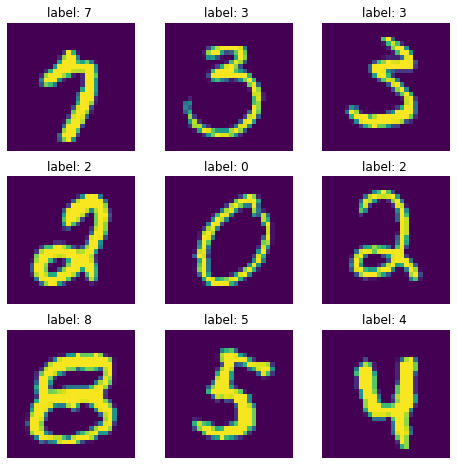

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title("label: {} ".format(label))
    plt.axis("off")
    plt.imshow(img.squeeze(0))
plt.show()

## Definition of the Discriminator and Generator Networks

For GANs the convergence is often problematic and dependent on the network layouts.

The simplest architecture for the discriminator and generator network which I came across is taken from https://github.com/lyeoni/pytorch-mnist-GAN/blob/master/pytorch-mnist-GAN.ipynb
where both networks are just feedforward neural networks.

Another example for a well converging GAN architecture with more efficient convolution layers is the deep convolutional GAN (DCGAN) https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html .

### Definition of the Discriminator Network

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size**2, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)

    # forward method,
    def discriminate(self, images):
        x = torch.flatten(images, 1) #flatten all dimensions except batch
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.dropout(x, 0.3)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = F.dropout(x, 0.3)
        x = torch.sigmoid(self.fc4(x))
        return x

### Definition of the Generator Network

In [5]:
class Generator(nn.Module):
    def __init__(self, input_size, dimensionality_latent_distribution):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(dimensionality_latent_distribution, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, input_size**2)
        self.input_size = input_size
    
    # forward method
    def generate(self, input_noise):
        x = F.leaky_relu(self.fc1(input_noise), 0.2)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = torch.tanh(self.fc4(x))
        x = torch.reshape(x, (x.shape[0], self.input_size, self.input_size))
        return x.unsqueeze(1)

Next we obtain the instances of our discriminator network and the generator network and the optimizers for the discriminator and the generator.

In [6]:
dimensionality_latent_distribution = 40
myDiscriminator = Discriminator(input_size=28)
myGenerator = Generator(
    input_size=28, dimensionality_latent_distribution=dimensionality_latent_distribution)

lr = 0.0002
optimizer_discriminator = optim.Adam(
    myDiscriminator.parameters(), lr=lr)
optimizer_generator = optim.Adam(myGenerator.parameters(), lr=lr)

Next, we define the training procedure consisting of two steps:
1. Training the discriminator which tries to estimate the probability $D_\theta = q_\theta$ that some data from the training set is real or generated. The training set is periodically updated to contain real data as well as newly generated fake data. We maximize the log-likelihood $\log(\mathcal{L}(\theta))$ (i.e. minimize the cross entropy $H(p,q)=-E_p(\log(q_\theta))=-\sum_i p(X=i) \log(q_\theta(X=i)$, see [relation to cross entropy](https://en.wikipedia.org/wiki/Cross_entropy#Relation_to_log-likelihood) ) with respect to the parameters $\theta$ of the discriminator. When the data in the training set $\{x_i\}$ is distributed according to $x_i \sim p(X=x_i)$ being real or fake, then we have $l_D=H\approx - \frac{1}{N} \sum_i \log(q_\theta(x_i))$ which we minimize with respect to the discriminator parameters $\theta$.
2. Training the generator has the goal to trick the generator into classifying the generated data as real. In a zero-sum game, the loss of the generator would be $l_G=-l_D$ such that the sum is zero. This game suffers in practice from the problem that the gradient of the loss of the generator [can become small](https://arxiv.org/pdf/1701.00160.pdf). Therefore, an altered heuristic game is proposed (which is not a zero-sum game), where we maximize the probability returned by the discriminator on the generated samples $D(G_\gamma(z_i))$ with respect to the parameters  $\gamma$ of the generator. Since the logarithm does not change the location of the maximum, we can also maximize $E_z[\log(D(G_\gamma(z_i)))]$ with respect to $\gamma$ (or minimize $-E_z[\log(D(G_\gamma(z_i)))]$, which can be done via the binary_cross_entropy and setting the target value to 1).

Note that we add regularizing terms in the training of the discriminator as proposed in [Which Training Methods for GANs do actually Converge?](https://arxiv.org/pdf/1801.04406.pdf) for helping convergence. The main point is to "penalize the discriminator for deviating from the Nash-equilibrium" after it made the generator produce data similar to the target distribution.

In [7]:
valid = 0.9*torch.ones(mb_size).unsqueeze(1) #one sided label smoothing, see https://arxiv.org/pdf/1701.00160.pdf and https://arxiv.org/pdf/1606.03498.pdf
invalid = torch.zeros(mb_size).unsqueeze(1)

#taken from https://github.com/LMescheder/GAN_stability/blob/1c8fe0d22fc023f7690bca19929cc8d6aa58875e/gan_training/train.py#L123
def compute_grad2(d_out, x_in):
    batch_size = x_in.size(0)
    grad_dout = autograd.grad(
        outputs=d_out.sum(), inputs=x_in,
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    grad_dout2 = grad_dout.pow(2)
    assert(grad_dout2.size() == x_in.size())
    reg = grad_dout2.view(batch_size, -1).sum(1)
    return reg

def train_discriminator(input_noises):
    optimizer_discriminator.zero_grad()
    
    real_images.requires_grad_() #for enabling regularization
    
    # discriminate real images
    verdict_real_images = myDiscriminator.discriminate(real_images)
    loss_real_discriminator = F.binary_cross_entropy(
        verdict_real_images, target=valid, reduction="sum")/mb_size

    # compute loss on real data and propagate it
    loss_real_discriminator.backward(retain_graph=True)
    
    # compute regularization on real data
    reg_param = 10
    regularization_real = reg_param * compute_grad2(verdict_real_images, real_images).mean()
    regularization_real.backward()    
    
    # generate fake images
    with torch.no_grad():
        fake_images = myGenerator.generate(input_noises)
    fake_images.requires_grad_() #for enabling regularization
    verdict_fake_images = myDiscriminator.discriminate(fake_images)
    # discriminate fake images
    loss_fake_discriminator = F.binary_cross_entropy(
        verdict_fake_images, target=invalid, reduction="sum")/mb_size
    
    # compute loss on fake data and propagate it
    loss_fake_discriminator.backward(retain_graph=True)
    
    # compute regularization on fake data proposed in https://arxiv.org/pdf/1801.04406.pdf
    regularization_fake = reg_param * compute_grad2(verdict_fake_images, fake_images).mean()
    regularization_fake.backward()
       
    optimizer_discriminator.step()
    return (loss_fake_discriminator+loss_real_discriminator).detach().numpy()


def train_generator(input_noises):
    optimizer_generator.zero_grad()
    
    fake_images = myGenerator.generate(input_noises)
    verdict_fake_images = myDiscriminator.discriminate(fake_images)

    loss_fake_generator = F.binary_cross_entropy(
        verdict_fake_images, target=valid, reduction="sum")/mb_size

    loss_fake_generator.backward()
    optimizer_generator.step()
    return loss_fake_generator.detach().numpy(), fake_images.detach()

In [8]:
print("numer of parameters myDiscriminator", sum(dict((p.data_ptr(), p.numel())
      for p in myDiscriminator.parameters()).values()))
print("numer of parameters myGenerator", sum(dict((p.data_ptr(), p.numel())
      for p in myGenerator.parameters()).values()))

numer of parameters myDiscriminator 1460225
numer of parameters myGenerator 1470992


Epoch 0, Loss generator 0.692054033279419, loss discriminator 1.3980541229248047


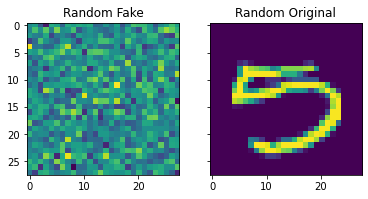

Epoch 0, Loss generator 1.175122618675232, loss discriminator 0.8602097034454346


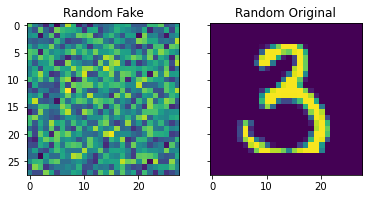

Epoch 0, Loss generator 1.2664456367492676, loss discriminator 0.7035186886787415


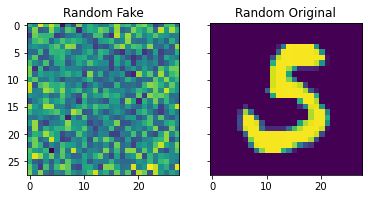

Epoch 0, Loss generator 0.840229332447052, loss discriminator 0.9197788238525391


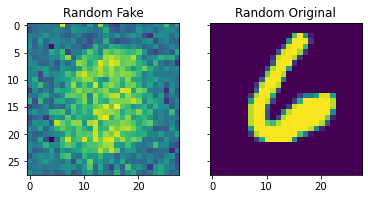

Epoch 0, Loss generator 1.4368069171905518, loss discriminator 0.6845890879631042


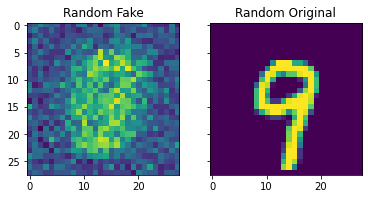

Epoch 0, Loss generator 0.8429263234138489, loss discriminator 0.9919508695602417


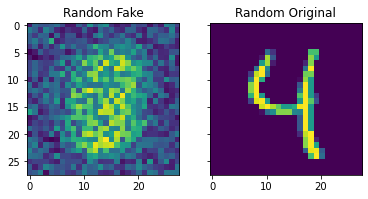

Epoch 0, Loss generator 1.0298596620559692, loss discriminator 0.7938159704208374


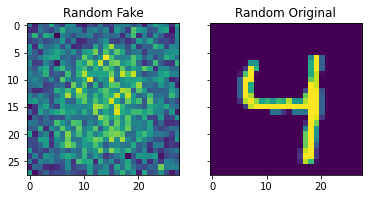

Epoch 0, Loss generator 0.9891313910484314, loss discriminator 1.0520402193069458


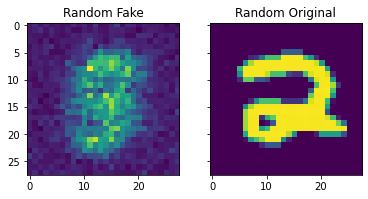

Epoch 0, Loss generator 0.9401661157608032, loss discriminator 0.9875501990318298


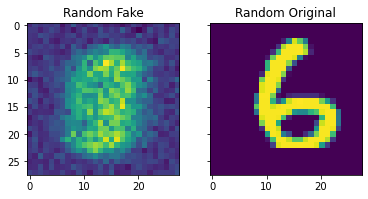

Epoch 0, Loss generator 1.088670015335083, loss discriminator 0.826641321182251


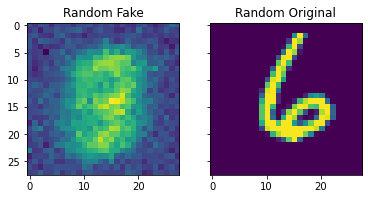

Epoch 0, Loss generator 1.1410760879516602, loss discriminator 0.7678816318511963


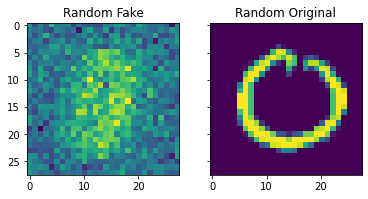

Epoch 0, Loss generator 1.8868470191955566, loss discriminator 0.5776095390319824


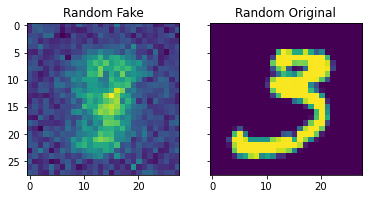

Epoch 1, Loss generator 0.9199896454811096, loss discriminator 1.4620764255523682


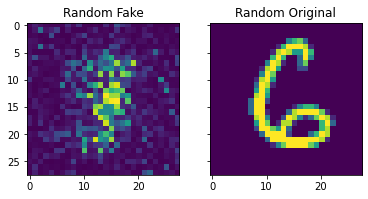

Epoch 1, Loss generator 3.851773262023926, loss discriminator 0.5321165323257446


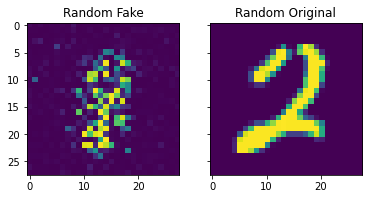

Epoch 1, Loss generator 2.8391506671905518, loss discriminator 0.6865438222885132


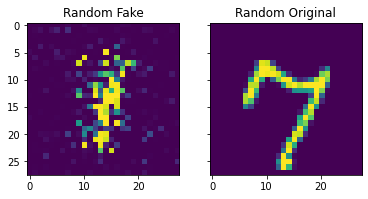

Epoch 1, Loss generator 5.712038516998291, loss discriminator 0.4054413139820099


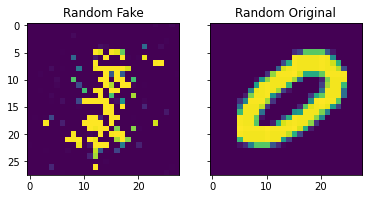

Epoch 1, Loss generator 4.978494644165039, loss discriminator 0.41740113496780396


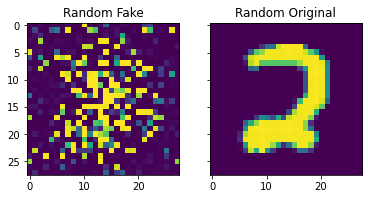

Epoch 1, Loss generator 5.75478458404541, loss discriminator 0.3995901644229889


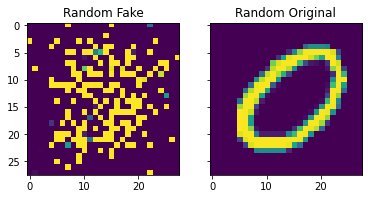

Epoch 1, Loss generator 5.477072238922119, loss discriminator 0.38167136907577515


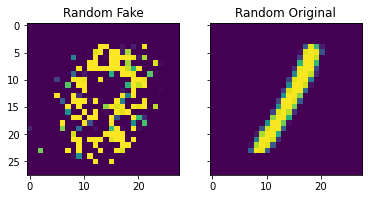

Epoch 1, Loss generator 4.421253681182861, loss discriminator 0.37767645716667175


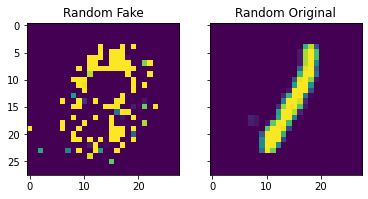

Epoch 1, Loss generator 4.865682601928711, loss discriminator 0.3774295449256897


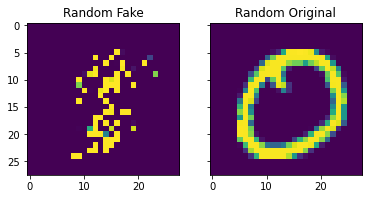

Epoch 1, Loss generator 3.7260122299194336, loss discriminator 0.49257150292396545


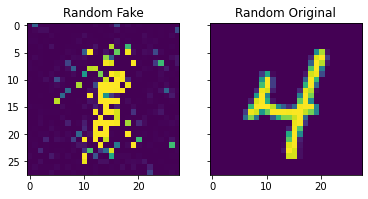

Epoch 1, Loss generator 4.8690185546875, loss discriminator 0.4031517505645752


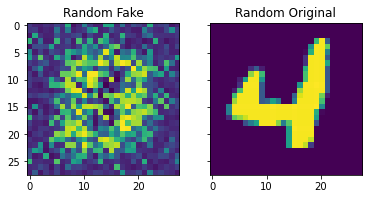

Epoch 1, Loss generator 4.163473606109619, loss discriminator 0.49740734696388245


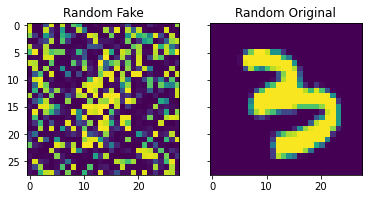

Epoch 2, Loss generator 3.392936944961548, loss discriminator 0.49894097447395325


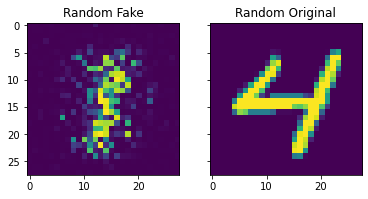

Epoch 2, Loss generator 2.4296460151672363, loss discriminator 0.6250744462013245


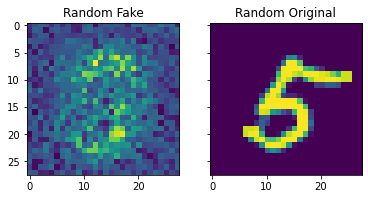

Epoch 2, Loss generator 3.2117068767547607, loss discriminator 0.46838122606277466


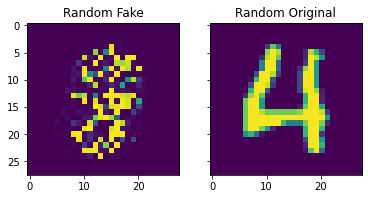

Epoch 2, Loss generator 2.7016305923461914, loss discriminator 0.49575257301330566


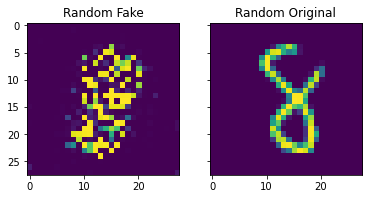

Epoch 2, Loss generator 2.0734217166900635, loss discriminator 0.5319643020629883


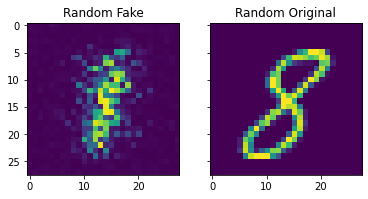

Epoch 2, Loss generator 1.545384168624878, loss discriminator 0.652165949344635


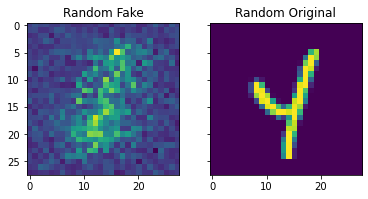

Epoch 2, Loss generator 1.5317610502243042, loss discriminator 0.6348497867584229


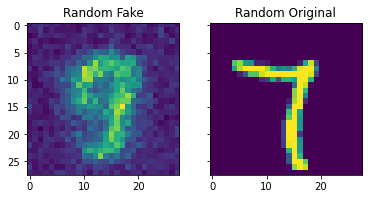

Epoch 2, Loss generator 1.5230973958969116, loss discriminator 0.6945385932922363


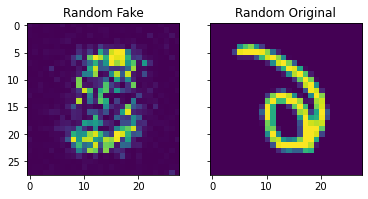

Epoch 2, Loss generator 1.7962127923965454, loss discriminator 0.7091075778007507


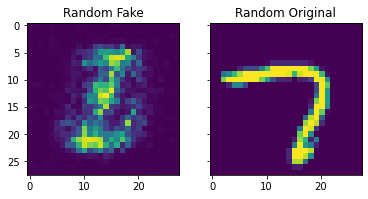

Epoch 2, Loss generator 1.9142779111862183, loss discriminator 0.7716485857963562


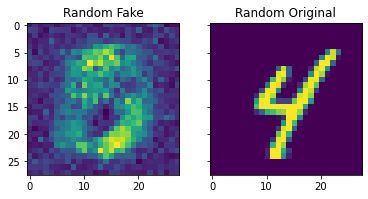

Epoch 2, Loss generator 2.3655059337615967, loss discriminator 0.543575644493103


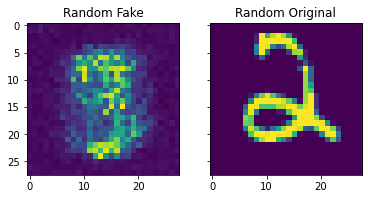

Epoch 2, Loss generator 2.346158981323242, loss discriminator 0.6161474585533142


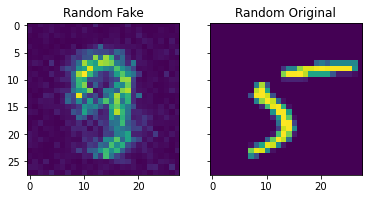

Epoch 3, Loss generator 1.2036422491073608, loss discriminator 0.83930504322052


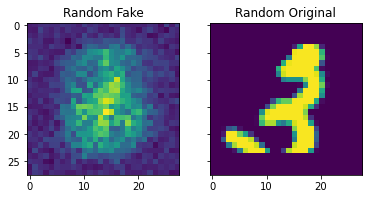

Epoch 3, Loss generator 1.4672644138336182, loss discriminator 0.7493978142738342


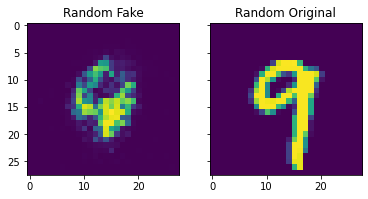

Epoch 3, Loss generator 1.3020669221878052, loss discriminator 0.8324374556541443


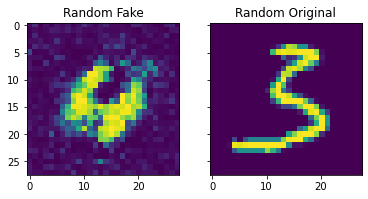

Epoch 3, Loss generator 1.5059387683868408, loss discriminator 0.7413715124130249


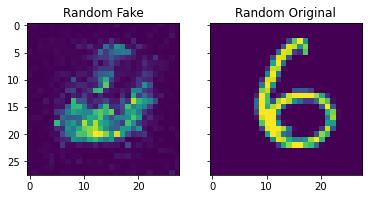

Epoch 3, Loss generator 1.5597032308578491, loss discriminator 0.7127784490585327


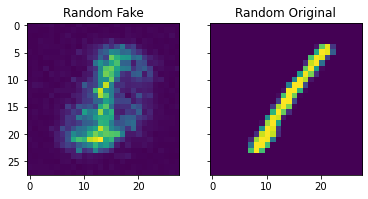

Epoch 3, Loss generator 1.7934666872024536, loss discriminator 0.763555109500885


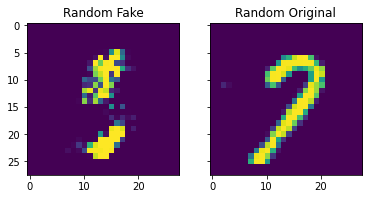

Epoch 3, Loss generator 1.6641079187393188, loss discriminator 0.7146816253662109


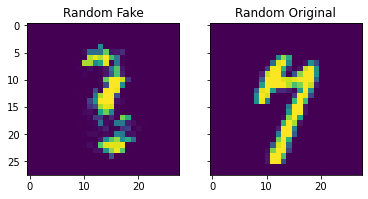

Epoch 3, Loss generator 1.6807445287704468, loss discriminator 0.7667160034179688


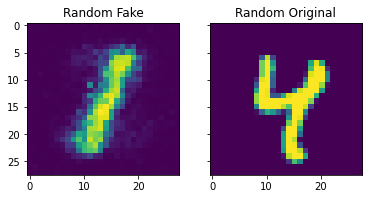

Epoch 3, Loss generator 1.77693772315979, loss discriminator 0.732442319393158


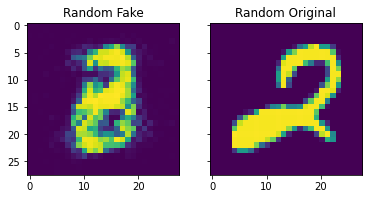

Epoch 3, Loss generator 1.6822330951690674, loss discriminator 0.6851341128349304


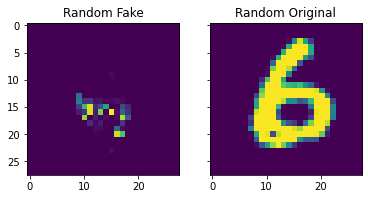

Epoch 3, Loss generator 1.535638689994812, loss discriminator 0.7890045046806335


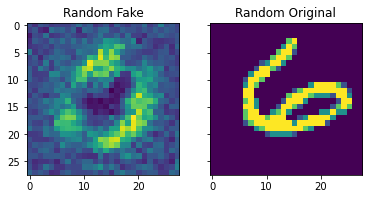

Epoch 3, Loss generator 1.7854013442993164, loss discriminator 0.7198227643966675


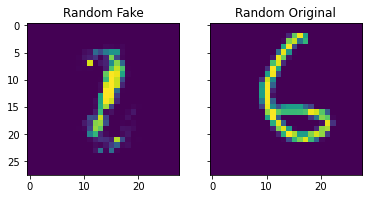

Epoch 4, Loss generator 1.6466431617736816, loss discriminator 0.7374956607818604


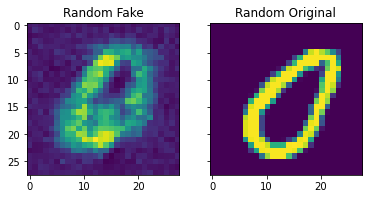

Epoch 4, Loss generator 1.6240794658660889, loss discriminator 0.7293864488601685


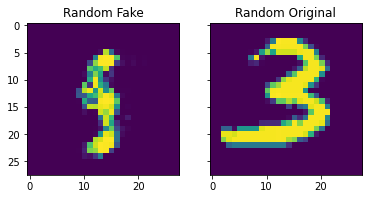

Epoch 4, Loss generator 1.5980573892593384, loss discriminator 0.7942256927490234


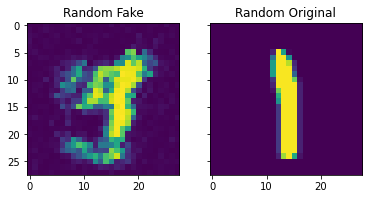

Epoch 4, Loss generator 1.884018898010254, loss discriminator 0.6613455414772034


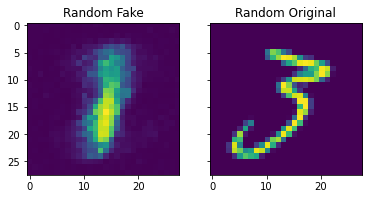

Epoch 4, Loss generator 1.8916374444961548, loss discriminator 0.6571372151374817


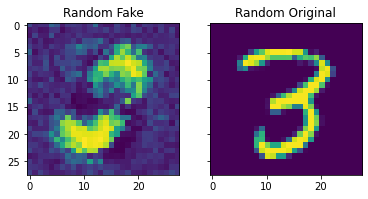

Epoch 4, Loss generator 1.489233374595642, loss discriminator 0.7644174098968506


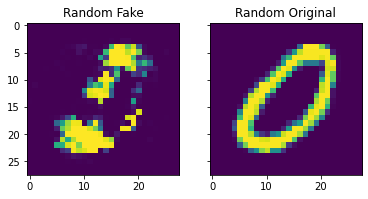

Epoch 4, Loss generator 1.5385187864303589, loss discriminator 0.7787052392959595


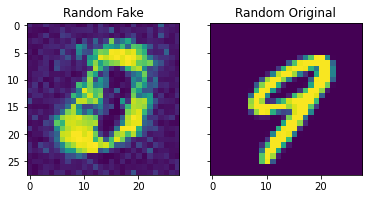

Epoch 4, Loss generator 1.6997979879379272, loss discriminator 0.7100350856781006


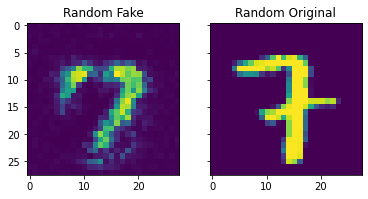

Epoch 4, Loss generator 1.6560308933258057, loss discriminator 0.7505311965942383


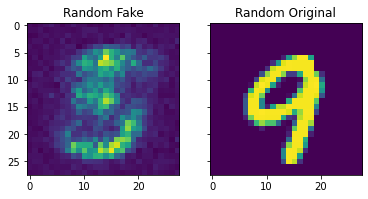

Epoch 4, Loss generator 1.6760566234588623, loss discriminator 0.7538520097732544


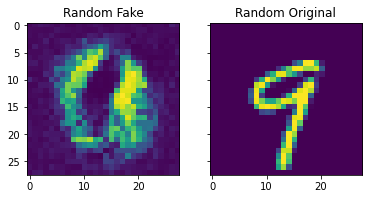

Epoch 4, Loss generator 1.2310041189193726, loss discriminator 0.8796420097351074


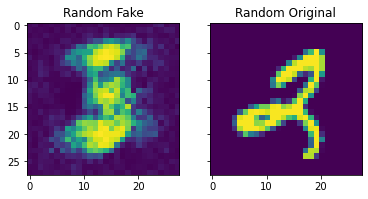

Epoch 4, Loss generator 1.8091654777526855, loss discriminator 0.7368021011352539


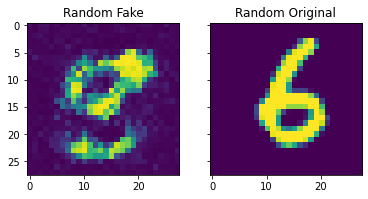

Epoch 5, Loss generator 1.592838168144226, loss discriminator 0.7722694277763367


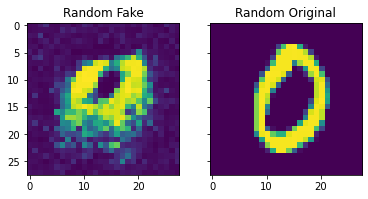

Epoch 5, Loss generator 1.3429983854293823, loss discriminator 0.8706075549125671


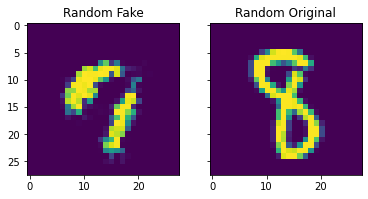

Epoch 5, Loss generator 1.4175807237625122, loss discriminator 0.7432327270507812


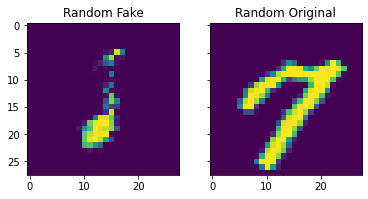

Epoch 5, Loss generator 1.5766407251358032, loss discriminator 0.8344035148620605


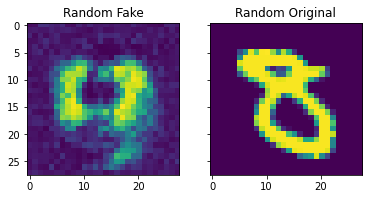

Epoch 5, Loss generator 1.4855519533157349, loss discriminator 0.8721040487289429


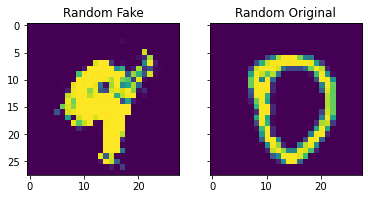

Epoch 5, Loss generator 1.2383055686950684, loss discriminator 0.9005963206291199


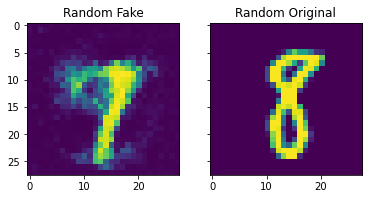

Epoch 5, Loss generator 1.408024787902832, loss discriminator 0.8133992552757263


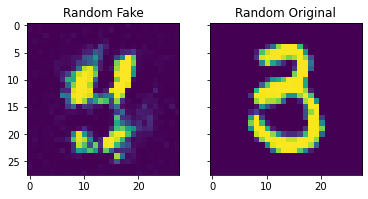

Epoch 5, Loss generator 1.4296361207962036, loss discriminator 0.78730309009552


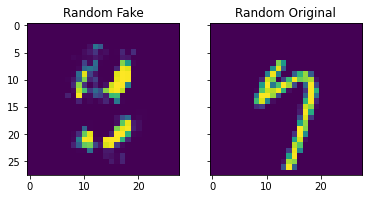

Epoch 5, Loss generator 1.4944325685501099, loss discriminator 0.8878371715545654


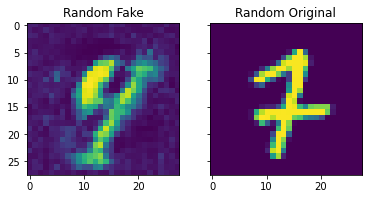

Epoch 5, Loss generator 1.3946974277496338, loss discriminator 0.921116292476654


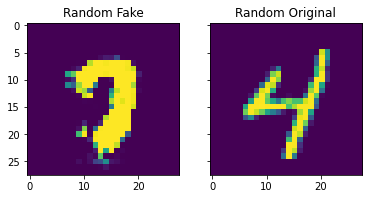

Epoch 5, Loss generator 1.334073543548584, loss discriminator 0.8721193075180054


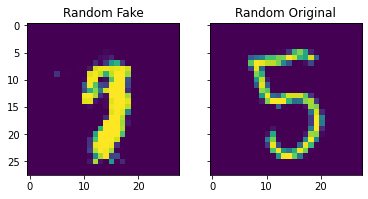

Epoch 5, Loss generator 1.4105366468429565, loss discriminator 0.8239256739616394


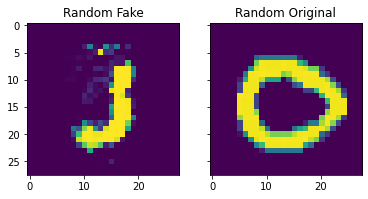

Epoch 6, Loss generator 1.4150751829147339, loss discriminator 0.8214849233627319


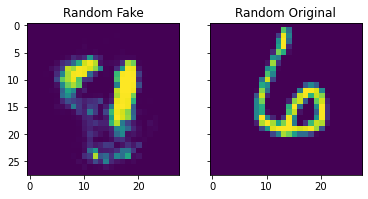

Epoch 6, Loss generator 1.3695707321166992, loss discriminator 0.8848837614059448


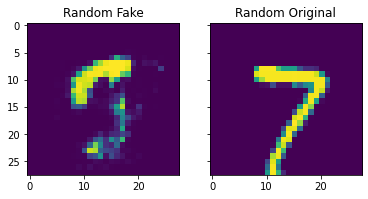

Epoch 6, Loss generator 1.3594781160354614, loss discriminator 0.8233143091201782


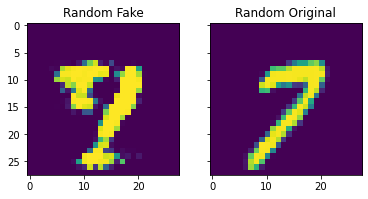

Epoch 6, Loss generator 1.3397619724273682, loss discriminator 0.8541903495788574


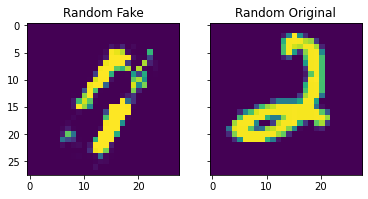

Epoch 6, Loss generator 1.364836573600769, loss discriminator 0.8392356038093567


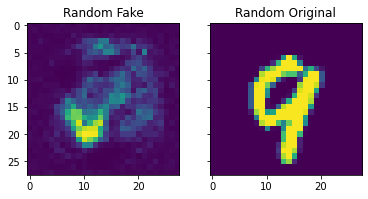

Epoch 6, Loss generator 1.4123578071594238, loss discriminator 0.8951982259750366


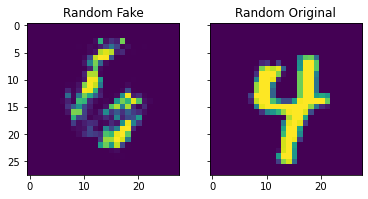

Epoch 6, Loss generator 1.252785563468933, loss discriminator 0.8817668557167053


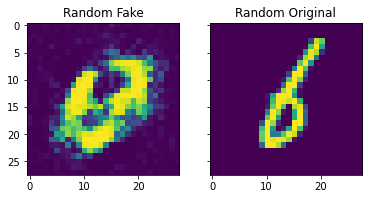

Epoch 6, Loss generator 1.3593461513519287, loss discriminator 0.8971969485282898


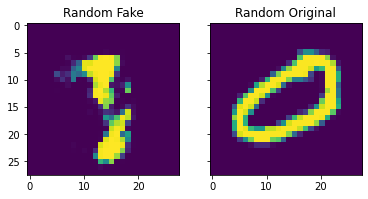

Epoch 6, Loss generator 1.4041383266448975, loss discriminator 0.871832549571991


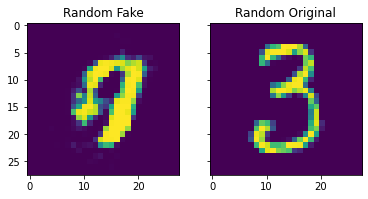

Epoch 6, Loss generator 1.4341692924499512, loss discriminator 0.8914521932601929


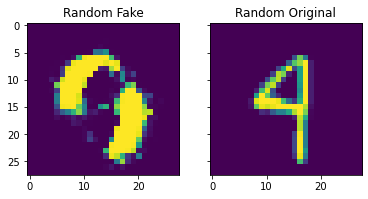

Epoch 6, Loss generator 1.338781476020813, loss discriminator 0.9977813959121704


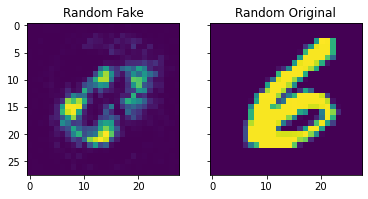

Epoch 6, Loss generator 1.2684295177459717, loss discriminator 0.986627995967865


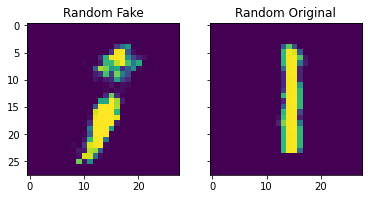

Epoch 7, Loss generator 1.36298406124115, loss discriminator 0.9119486808776855


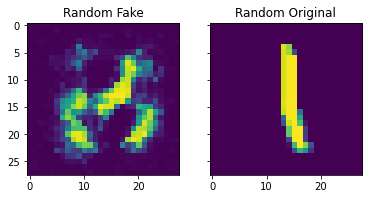

Epoch 7, Loss generator 1.4422540664672852, loss discriminator 0.8657563924789429


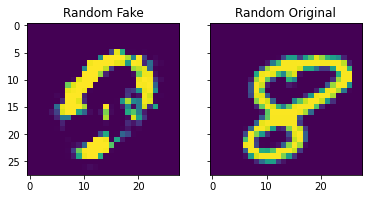

Epoch 7, Loss generator 1.464542031288147, loss discriminator 0.8755733966827393


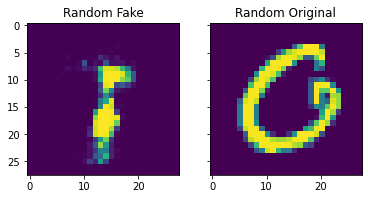

Epoch 7, Loss generator 1.6435045003890991, loss discriminator 0.811782717704773


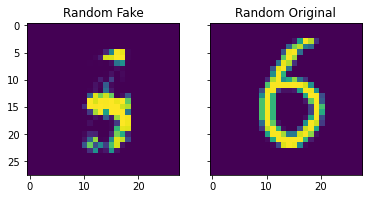

Epoch 7, Loss generator 1.3949289321899414, loss discriminator 0.9046539068222046


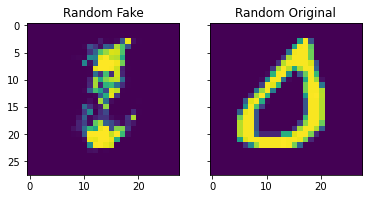

Epoch 7, Loss generator 1.4568185806274414, loss discriminator 0.9556742906570435


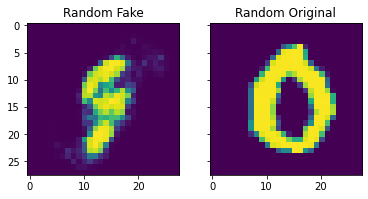

Epoch 7, Loss generator 1.2289897203445435, loss discriminator 0.9332826137542725


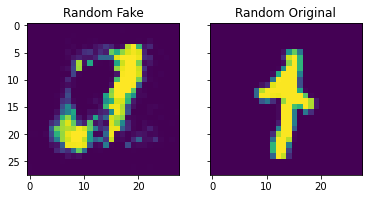

Epoch 7, Loss generator 1.1554381847381592, loss discriminator 0.9823662638664246


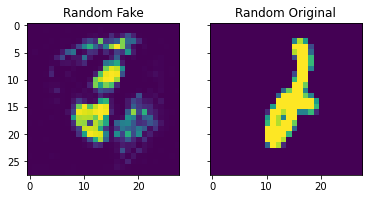

Epoch 7, Loss generator 1.3450255393981934, loss discriminator 0.8951530456542969


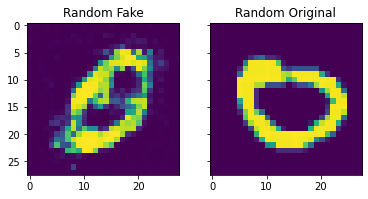

Epoch 7, Loss generator 1.2184453010559082, loss discriminator 0.9198520183563232


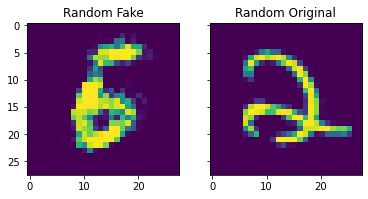

Epoch 7, Loss generator 1.4894758462905884, loss discriminator 0.9017776250839233


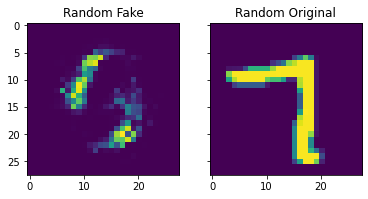

Epoch 7, Loss generator 1.4151904582977295, loss discriminator 0.9140781164169312


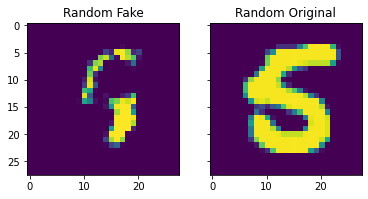

Epoch 8, Loss generator 1.4749054908752441, loss discriminator 0.871898353099823


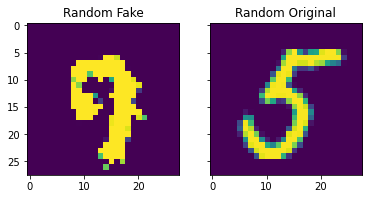

Epoch 8, Loss generator 1.4800077676773071, loss discriminator 0.8555665016174316


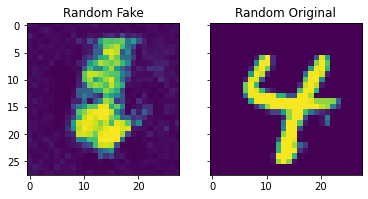

Epoch 8, Loss generator 1.086282730102539, loss discriminator 0.9725472927093506


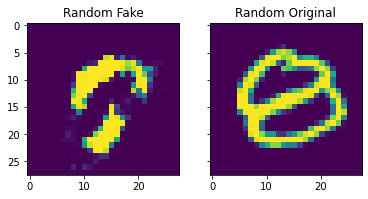

Epoch 8, Loss generator 1.3720006942749023, loss discriminator 0.8822305202484131


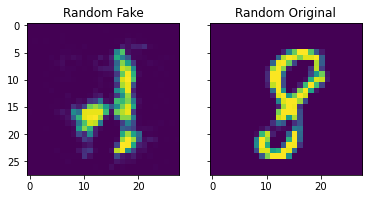

Epoch 8, Loss generator 1.362882137298584, loss discriminator 0.8700571060180664


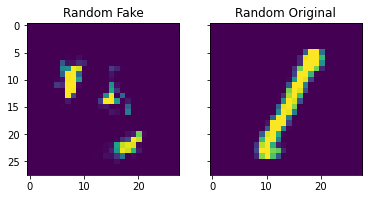

Epoch 8, Loss generator 1.2588982582092285, loss discriminator 0.9262683391571045


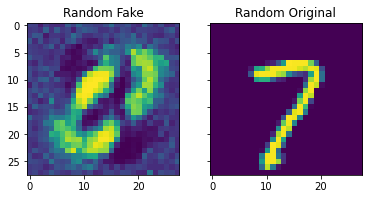

Epoch 8, Loss generator 1.274247646331787, loss discriminator 0.8684056401252747


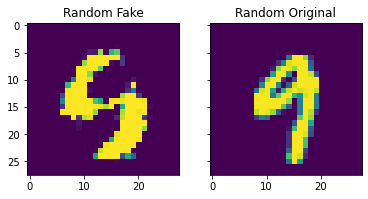

Epoch 8, Loss generator 1.3407378196716309, loss discriminator 0.838387131690979


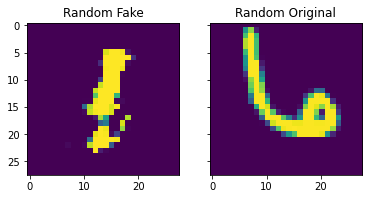

Epoch 8, Loss generator 1.1784764528274536, loss discriminator 0.8765013217926025


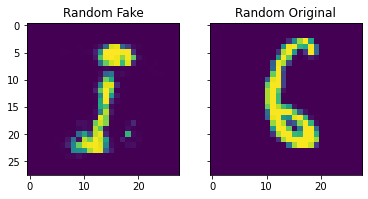

Epoch 8, Loss generator 1.2162446975708008, loss discriminator 0.9835147857666016


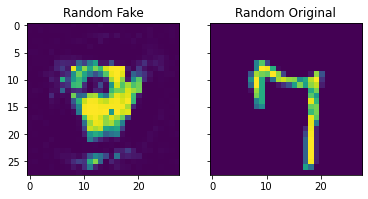

Epoch 8, Loss generator 1.1614716053009033, loss discriminator 1.007948875427246


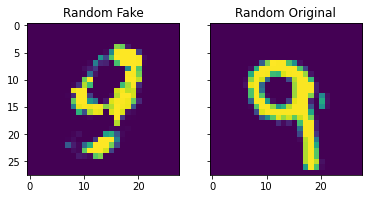

Epoch 8, Loss generator 1.3707562685012817, loss discriminator 0.8279749155044556


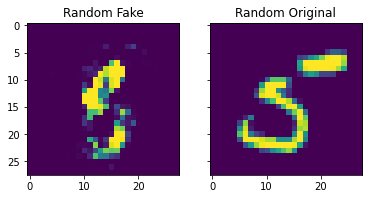

Epoch 9, Loss generator 1.4363666772842407, loss discriminator 0.8913530111312866


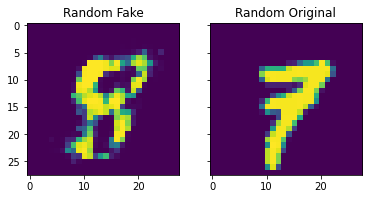

Epoch 9, Loss generator 1.29640793800354, loss discriminator 0.8890150785446167


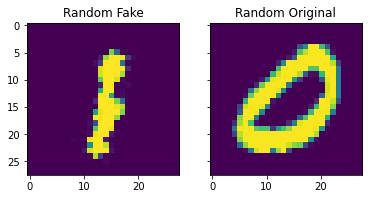

Epoch 9, Loss generator 1.480480670928955, loss discriminator 0.8708076477050781


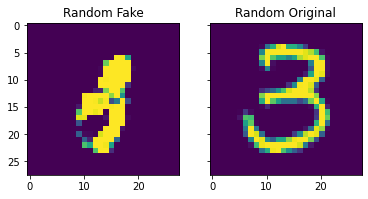

Epoch 9, Loss generator 1.2505805492401123, loss discriminator 0.9718074798583984


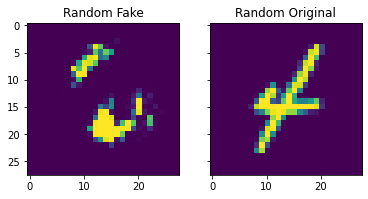

Epoch 9, Loss generator 1.1866511106491089, loss discriminator 0.9129077196121216


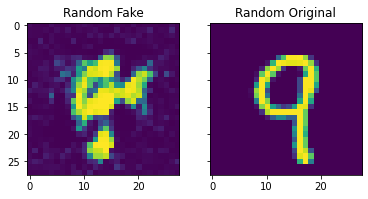

Epoch 9, Loss generator 1.3120919466018677, loss discriminator 0.9081660509109497


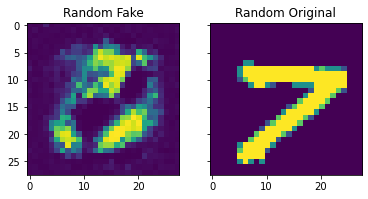

Epoch 9, Loss generator 1.3830777406692505, loss discriminator 0.9401010274887085


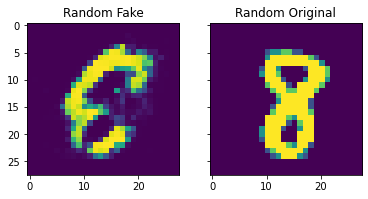

Epoch 9, Loss generator 1.3210171461105347, loss discriminator 0.9953831434249878


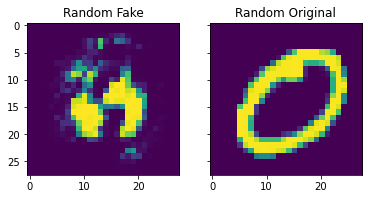

Epoch 9, Loss generator 1.3730899095535278, loss discriminator 0.9392386674880981


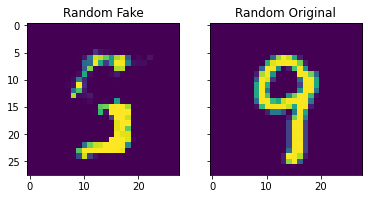

Epoch 9, Loss generator 1.2145466804504395, loss discriminator 1.0038483142852783


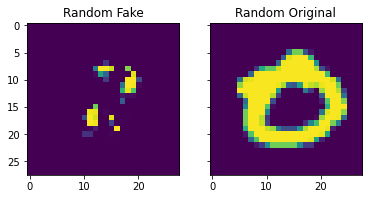

Epoch 9, Loss generator 1.267500400543213, loss discriminator 0.9618638753890991


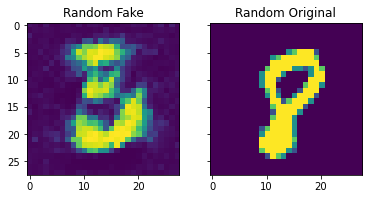

Epoch 9, Loss generator 1.2992912530899048, loss discriminator 1.0229966640472412


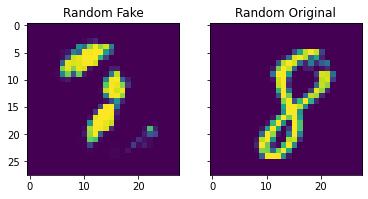

In [9]:
epochs = 10
for i in range(epochs):
    loss_discriminator = np.nan
    loss_fake_generator = np.nan
    for batch_idx, (real_images, real_labels) in enumerate(data_loader):
        real_labels = torch.nn.functional.one_hot(real_labels)

        input_noises = torch.randn(mb_size, dimensionality_latent_distribution)
        loss_discriminator = train_discriminator(input_noises)

        input_noises = torch.randn(mb_size, dimensionality_latent_distribution)
        loss_fake_generator, fake_images = train_generator(input_noises)

        if(batch_idx % 50 == 0):
            print("Epoch {}, Loss generator {}, loss discriminator {}".format(
                i, loss_fake_generator, loss_discriminator))
            f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
            ax1.imshow(fake_images[0].squeeze(0).detach().numpy())
            ax1.set_title('Random Fake')
            ax2.set_title('Random Original')
            ax2.imshow(real_images[0].squeeze(0).detach().numpy())
            plt.show()

After 9 epochs the GAN converges to results which look similar to training digits in the MNIST dataset. We can sample from the generator via supplying some noise as input:

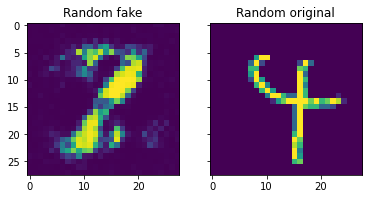

In [10]:
input_noises = torch.randn(mb_size, dimensionality_latent_distribution)
fake_images = myGenerator.generate(input_noises)
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(fake_images[90].squeeze(0).detach().numpy())
ax1.set_title('Random fake')
ax2.set_title('Random original')
ax2.imshow(real_images[0].squeeze(0).detach().numpy())
plt.show()